In [1]:
%matplotlib inline

In [67]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.datasets import Datasets, MapDataset
from gammapy.data import Observation, observatory_locations
from regions import CircleSkyRegion
from scipy.stats import chi2, norm

import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling import Fit


In [3]:
!gammapy info --no-envvar --no-dependencies --no-system


Gammapy package:

	version                : 0.20.1     
	path                   : D:\Documents\Miniconda\envs\gammapy-0.20.1\lib\site-packages\gammapy 



In [4]:
# Loading IRFs
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [5]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 6.0 * u.hr
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")

In [6]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(6, 6),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(
    geom, name="dataset-simu", energy_axis_true=energy_true
)

In [7]:
# Create an in-memory observation
location = observatory_locations["cta_south"]
obs = Observation.create(
    pointing=pointing, livetime=livetime, irfs=irfs, location=location
)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.25
	duration          : 21600.00 s
	pointing (icrs)   : 266.4 deg, -28.9 deg

	deadtime fraction : 0.0%



In [84]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)


MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 0 
  Total background counts         : 483752.84
  Total excess counts             : -483752.84

  Predicted counts                : 483752.84
  Predicted background counts     : 483752.84
  Predicted excess counts         : nan

  Exposure min                    : 1.22e+03 m2 s
  Exposure max                    : 1.07e+11 m2 s

  Number of total bins            : 810000 
  Number of fit bins              : 804492 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [9]:
def simulate_dataset(empty_dataset, models):
    empty_dataset.models = models
    empty_dataset.fake()
    return empty_dataset

In [30]:
def fit_dataset(dataset):
    fit = Fit(optimize_opts={"print_level": 1})
    result = fit.run(datasets=[dataset])
    return dataset

In [85]:
def simulate_range(vary_bkg=False):
    bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")
    if vary_bkg==True:
        bkg_model.spectral_model.norm.value = np.random.normal(1,0.1)
        bkg_model.spectral_model.tilt.value = np.random.normal(0,0.05)
        
    spectral_model=PowerLawSpectralModel(
        amplitude="1e-11 cm-2 s-1 TeV-1", index=3, reference="1 TeV"
    )
    spatial_model=GaussianSpatialModel(
        lon_0="0.1 deg", lat_0="0.1 deg", frame="galactic"  
    )
    for rad in [0.5, 10]:
        spatial_model.sigma.value=rad
        model = SkyModel(spectral_model, spatial_model)
        models=Models([bkg_model,model])
        dataset = maker.run(empty, obs)
        dataset = maker_safe_mask.run(dataset, obs)
        simulated_dataset = simulate_dataset(dataset,models)
        # To plot, eg, counts:
        simulated_dataset.counts.smooth(0.05 * u.deg).plot_interactive(
            add_cbar=True, stretch="linear"
        )
        fit_result = fit_dataset(simulated_dataset)
        
        display(models.to_parameters_table())
        
        estimator = ExcessMapEstimator(
            correlation_radius="0.1 deg",
            selection_optional=[],
            energy_edges=[0.1, 1, 10] * u.TeV,
        )

        result = estimator.run(fit_result)
        result["sqrt_ts"].plot_grid(
            figsize=(12, 4), cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ncols=2
        )

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str16,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
dataset-simu-bkg,spectral,norm,9.8517e-01,,1.626e-03,nan,nan,False,True,
dataset-simu-bkg,spectral,tilt,-7.1237e-03,,0.000e+00,nan,nan,True,False,
dataset-simu-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
EfsPrpQ6,spectral,index,2.9595e+00,,1.418e-02,nan,nan,False,False,
EfsPrpQ6,spectral,amplitude,1.0624e-11,cm-2 s-1 TeV-1,2.558e-13,nan,nan,False,True,
EfsPrpQ6,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
EfsPrpQ6,spatial,lon_0,1.0522e-01,deg,7.682e-03,nan,nan,False,False,
EfsPrpQ6,spatial,lat_0,1.0371e-01,deg,7.780e-03,-9.000e+01,9.000e+01,False,False,
EfsPrpQ6,spatial,sigma,4.9591e-01,deg,5.594e-03,0.000e+00,nan,False,False,


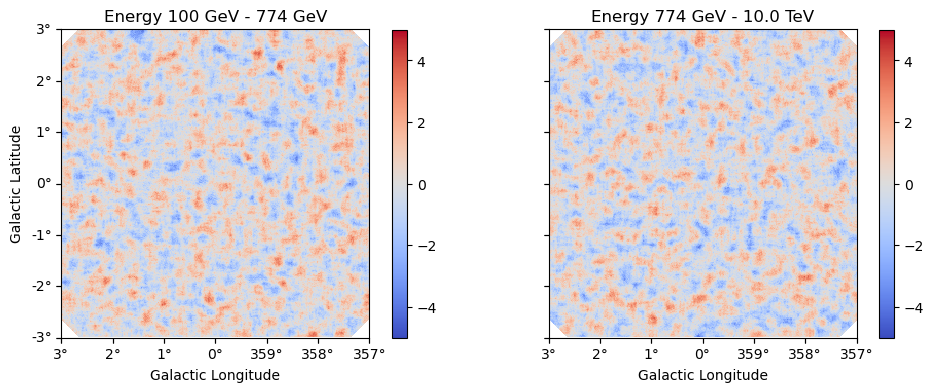

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

Position <SkyCoord (Galactic): (l, b) in deg
    (345.34216953, 0.10370839)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (345.34216953, 0.10370839)> is outside valid IRF map range, using nearest IRF defined within


W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Machine accuracy limits further improvement
W MnHesse 2nd derivative zero for parameter par_001_index ; MnHesse fails and will return diagonal matrix
W VariableMetricBuilder Invalid Hessian - exit the minimization
W VariableMetricBuilder No convergence; Edm 0.00491851 is above tolerance 0.002
W MnHesse 2nd derivative zero for parameter par_001_index ; MnHesse fails and will return diagonal matrix
W VariableMetricBuilder Invalid Hessian - exit the minimization
W MnHesse 2nd derivative zero for parameter par_001_index ; MnHesse fails and will return diagonal matrix
W VariableMetricBuilder Invalid Hessian - exit the minimization
W VariableMetricBuilder No improvement in line search
W MnHesse 2nd derivative zero for parameter par_001_index ; MnHesse fails and will return diagonal matrix
W VariableMetricBuilder Invalid Hessian - exit the minimization
W VariableMetricBuilder No improvement in line search
W MnHesse 

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str16,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
dataset-simu-bkg,spectral,norm,9.8560e-01,,nan,nan,nan,False,True,
dataset-simu-bkg,spectral,tilt,-7.1237e-03,,0.000e+00,nan,nan,True,False,
dataset-simu-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
0xXhO-Iv,spectral,index,2.9595e+00,,nan,nan,nan,False,False,
0xXhO-Iv,spectral,amplitude,1.0624e-11,cm-2 s-1 TeV-1,nan,nan,nan,False,True,
0xXhO-Iv,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
0xXhO-Iv,spatial,lon_0,-1.4658e+01,deg,nan,nan,nan,False,False,
0xXhO-Iv,spatial,lat_0,1.0371e-01,deg,nan,-9.000e+01,9.000e+01,False,False,
0xXhO-Iv,spatial,sigma,7.8782e+00,deg,nan,0.000e+00,nan,False,False,


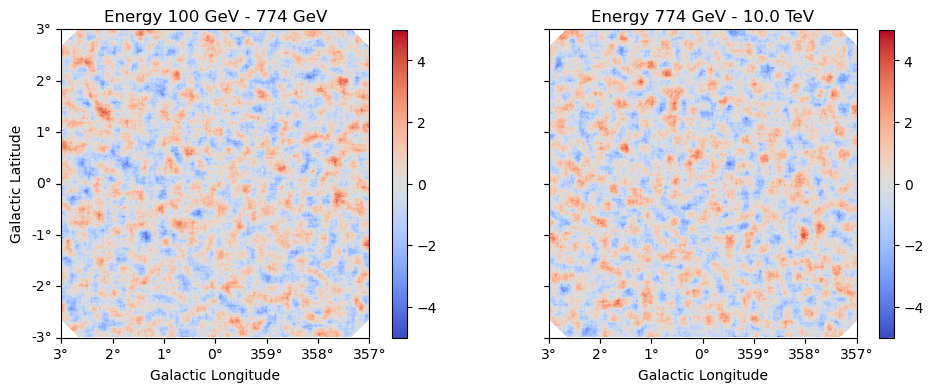

In [86]:
simulate_range(vary_bkg=True)